Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import urllib
import zipfile
from matplotlib import pylab
%matplotlib inline
from sklearn.manifold import TSNE

Download the data from the source website if necessary.
-----------

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    print statinfo.st_size
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


**Read the data into a string.**

In [4]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    print name, type(name)
    return f.read(name).split()
  f.close()
  
words = read_data(filename)
print 'Data size', len(words)

text8 <type 'str'>
Data size 17005207


** Build the dictionary and replace rare words with UNK token.**

In [5]:
## exclude words in stoplist
stoplist = set('for a b c d e f g h i j k l m n o p q r s t u v w x y z \
    an of th the and to in one two three four five six seven eight nine zero'.split())

In [6]:
words = [i for i in words if i not in stoplist]

In [7]:
vocabulary_size = 50000  # orig 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print 'Most common words (+UNK):'
print count[:15]
print 'Sample data (indexes of words):'
print data[:10]  # 
del words  # Hint to reduce memory.

Most common words (+UNK):
[['UNK', 417995], ('is', 183153), ('as', 131815), ('was', 112807), ('by', 111831), ('that', 109510), ('with', 95603), ('on', 91250), ('are', 76527), ('it', 73334), ('from', 72871), ('or', 68945), ('his', 62603), ('be', 61281), ('this', 58832)]
Sample data (indexes of words):
[5195, 3040, 2, 163, 3093, 27, 40, 126, 101, 700]


In [8]:
print len(data), data[-10:]
print len(count), count[-10:]

11633198 [318, 2760, 870, 6539, 390, 28097, 3, 1715, 3923, 13973]
50000 [('bookrags', 9), ('adjutant', 9), ('hamadan', 9), ('bhra', 9), ('kingsbridge', 9), ('gallatin', 9), ('safeties', 9), ('oicw', 9), ('garis', 9), ('consanguinity', 9)]


In [9]:
# begining of corpus, with indexes
for i in (data)[:10]:
    print reverse_dictionary[i], i

anarchism 5195
originated 3040
as 2
term 163
abuse 3093
first 27
used 40
against 126
early 101
working 700


In [10]:
# end of corpus, with indexes
for i in (data)[-20:]:
    print reverse_dictionary[i], i

final 487
UNK 0
his 12
followers 2943
prior 1251
mass 605
suicide 2572
verbatim 29424
romans 2404
site 390
today 318
platform 2760
access 870
fortress 6539
site 390
masada 28097
was 3
identified 1715
extensively 3923
excavated 13973


In [11]:
for i in dictionary.keys()[-5:]:
    print i, dictionary[i]

rotting 26403
pods 23237
emery 40133
northerly 23593
expands 14453


In [12]:
for i in reverse_dictionary.items()[:11]:
    print i

(0, 'UNK')
(1, 'is')
(2, 'as')
(3, 'was')
(4, 'by')
(5, 'that')
(6, 'with')
(7, 'on')
(8, 'are')
(9, 'it')
(10, 'from')


Function to generate a training batch for the skip-gram model.
----------

In [58]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size / num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print batch[i], '->', labels[i, 0]
  print reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]]

3040 -> 2
originated -> as
3040 -> 5195
originated -> anarchism
2 -> 3040
as -> originated
2 -> 163
as -> term
163 -> 2
term -> as
163 -> 3093
term -> abuse
3093 -> 27
abuse -> first
3093 -> 163
abuse -> term


Train a skip-gram model.
----------

In [59]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(xrange(1,valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)  ## 16 random from top 100
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print embed.get_shape().as_list()
  # Compute the softmax loss, using a sample of the negative labels each time.
  # https://www.tensorflow.org/versions/0.6.0/api_docs/python/nn.html#sampled_softmax_loss
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[200, 128]


In [60]:
num_steps = 100001  # 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized\n========="
  average_loss = 0
  for step in xrange(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, lz = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += lz
    if step % 5000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print "Average loss at step", step, ":", average_loss
      print "----------------------"
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print log
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0 : 6.72773551941
----------------------
Nearest to own: satirize, cardinal, acharya, token, decoction,
Nearest to others: uncommonly, merkle, judaeo, unexplored, broome,
Nearest to make: commutator, collapsed, romanized, quadrivium, wood,
Nearest to main: semitism, reinventing, naturalis, superheroic, huston,
Nearest to without: citrate, markov, immortality, presiding, wollheim,
Nearest to become: nn, seekers, quantities, carnatic, industrialist,
Nearest to place: logistical, underline, predestination, causality, champion,
Nearest to st: mitzvot, monopolies, levee, duddy, nonlinear,
Nearest to party: mulligan, tsunamis, lutherans, steaming, failing,
Nearest to include: pastimes, velar, davison, fierce, durrani,
Nearest to thus: bowlers, curt, cartel, posthumous, augmented,
Nearest to union: jehu, grooves, jagie, rowers, bacteriophage,
Nearest to given: constantinople, cannons, srivijaya, yorke, extraordinary,
Nearest to king: narrow, friesland, relaunc

** Look at embeddings **


In [29]:
num_points = 200

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [30]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

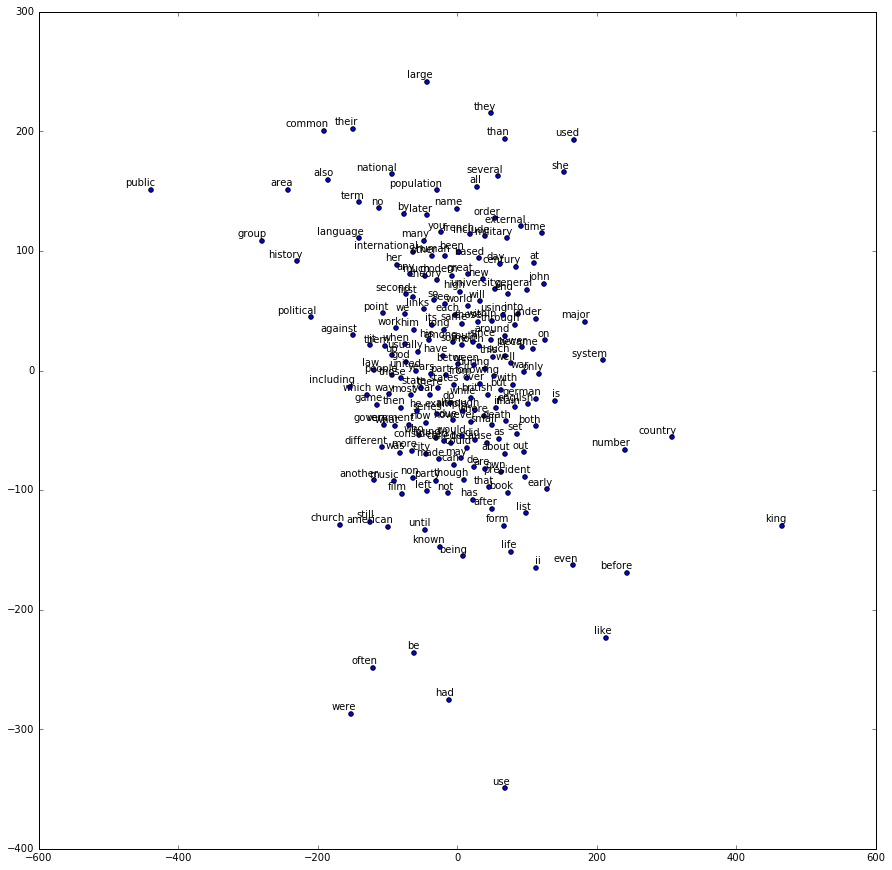

In [31]:
words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

> 3.1    Continuous Bag-of-Words Model

>The first proposed architecture is similar to the feedforward NNLM, where the non-linear hiddenlayer is removed and the projection layer is shared for all words (not just the projection matrix);thus, all words get projected into the same position (their vectors are averaged). 

>We call this archi-tecture a bag-of-words model as the order of words in the history does not influence the projection. Furthermore, we also use words from the future.

>We have obtained the best performance on the task introduced in the next section by building a **log-linear classifier with four future and four history words at the input**, where the training criterion is to correctly **classify the current (middle) word**.

>Training complexity is then 

>`Q = N*D + D*log2(V)`
    
>We denote this model further as CBOW, as unlike standard bag-of-words model, it uses continuousdistributed representation of the context. The model architecture is shown at Figure 1. Note that theweight matrix between the input and the projection layer is shared for all word positions in the sameway as in the NNLM.

Generate training batch for CBOW
----------

In [76]:
data_index = 0

def gen_batch_cbow(batch_size, bag_window):
  global data_index
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  assert batch_size >= span
  batch = list()
  labels = np.ndarray(shape=(batch_size-(2*bag_window), 1), dtype=np.int32)
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  ## TODO: fix batch creation
  for i in range(bag_window, batch_size-bag_window):
    #print buffer
    batch.append([])
    for j in reversed(range(bag_window)):
      batch[i-bag_window].append(buffer[bag_window-1-j])
    for j in range(bag_window):
      batch[i-bag_window].append(buffer[bag_window+1+j])
    labels[i-bag_window] = buffer[bag_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return np.array(batch, dtype=np.int32), np.array(labels, dtype=np.int32)

batch, labels = gen_batch_cbow(batch_size=10, bag_window=3)

for i in range(2):
  print batch[i], '->', labels[i, 0]
  for j in batch[i]:
    print reverse_dictionary[j]
  print '->', reverse_dictionary[labels[i, 0]]
  print '---------'

[5195 3040    2 3093   27   40] -> 163
anarchism
originated
as
abuse
first
used
-> term
---------
[3040    2  163   27   40  126] -> 3093
originated
as
term
first
used
against
-> abuse
---------


** Building the graph, CBOW **

In [78]:
batch_size = 128
bag_window = 4 # How many words to consider left and right.
embedding_size = 128 # Dimension of the embedding vector.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(xrange(1,valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size-2*bag_window, 2*bag_window])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size-2*bag_window, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Model.
  ## split input data to look up embeddings one at a time
  ## possible issue with possible issue with >1 dim embedding lookup
  ## https://github.com/tensorflow/tensorflow/issues/505
  '''
  _emb = []                                                                                                                 
  for x in tf.split(1, 2*bag_window, train_dataset):
    buffer = tf.Variable(tf.zeros([batch_size-2*bag_window,1, embedding_size]))
    emb = tf.nn.embedding_lookup(embeddings, x)
    print emb.get_shape().as_list()
    buffer = tf.Variable.assign_add(buffer, emb)
    print 'buffer:', buffer.get_shape().as_list()
  sum_embed = tf.squeeze(buffer) / (2*bag_window)
  '''
  sum_embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset), 1)
  print sum_embed.get_shape().as_list()
  
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, sum_embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  ##optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  ## use gradient descent
  global_step = tf.Variable(0, trainable=False) # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(1.0, global_step, 1000, 0.9, staircase=False)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[120, 128]


** Run it, CBOW **

In [79]:
num_steps = 100001  # 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized\n========="
  average_loss = 0
  for step in xrange(num_steps):
    batch_data, batch_labels = gen_batch_cbow(batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, lz = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += lz
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print "Average loss at step", step, ":", average_loss
      print "----------------------"
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print log
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0 : 7.07733201981
----------------------
Nearest to war: sovereignty, mascarenes, various, bikram, differentiability,
Nearest to during: erfurt, emulsifiers, kyd, schuster, monotonous,
Nearest to also: disintegrating, habitations, colonels, bra, athanasian,
Nearest to english: ial, autocode, haldane, fringing, laren,
Nearest to are: anterior, antigen, alternating, analogously, hegelians,
Nearest to years: designator, gerhardt, fath, dictator, brooks,
Nearest to between: homophonic, horns, primrose, iquique, freeware,
Nearest to most: laodiceans, bachelor, autocrat, brewed, namely,
Nearest to new: cytoplasmic, synclavier, challenging, westward, perp,
Nearest to often: luthiers, alicante, singular, fasces, apathy,
Nearest to well: tenet, resolved, prescriptive, asroc, tta,
Nearest to their: correspondences, metaphors, photographing, misheard, midnight,
Nearest to can: cfp, breweries, benign, antonio, normandy,
Nearest to up: icmp, provision, determination

** Look at embedding in 2D**

In [80]:
num_points = 300

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [82]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

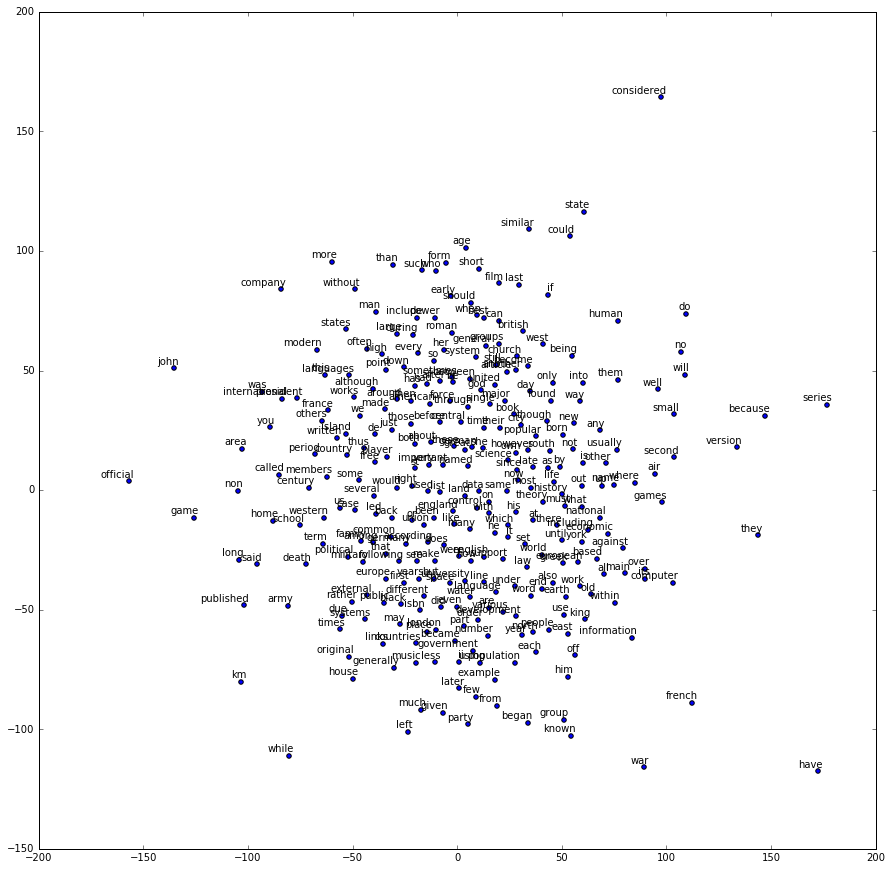

In [83]:
words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot(two_d_embeddings, words)

---

Scratchpad
----------

In [ ]:
  ## split input data to look up embeddings
  ## possible issue with possible issue with >1 dim embedding lookup
  ## https://github.com/tensorflow/tensorflow/issues/505
  _emb = []                                                                                                                 
  for x in tf.split(1, 2*bag_window, train_dataset):
    buffer = tf.Variable(tf.zeros([embedding_size]))
    emb = tf.nn.embedding_lookup(embeddings, x)
    print emb.get_shape().as_list()
    _emb.append(emb)
  embed = tf.concat(1, _emb)
  print embed.get_shape().as_list()
  sum_embed = tf.reduce_mean(embed, 1)
  print sum_embed.get_shape().as_list()